In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip /content/drive/MyDrive/HandGestures/data/LeapMotion/imgs.zip
# ! unzip /content/drive/MyDrive/HandGestures/data/TinyHGRSubset/subset_imgs.zip

Streaming output truncated to the last 5000 lines.
  inflating: pictures/ThumbDown/Thumb30.png  
  inflating: pictures/ThumbDown/Thumb24.png  
  inflating: pictures/ThumbDown/Thumb279.png  
  inflating: pictures/ThumbDown/Thumb1248.png  
  inflating: pictures/ThumbDown/Thumb251.png  
  inflating: pictures/ThumbDown/Thumb1260.png  
  inflating: pictures/ThumbDown/Thumb1506.png  
  inflating: pictures/ThumbDown/Thumb537.png  
  inflating: pictures/ThumbDown/Thumb523.png  
  inflating: pictures/ThumbDown/Thumb1512.png  
  inflating: pictures/ThumbDown/Thumb18.png  
  inflating: pictures/ThumbDown/Thumb1274.png  
  inflating: pictures/ThumbDown/Thumb245.png  
  inflating: pictures/ThumbDown/Thumb292.png  
  inflating: pictures/ThumbDown/Thumb286.png  
  inflating: pictures/ThumbDown/Thumb1738.png  
  inflating: pictures/ThumbDown/Thumb709.png  
  inflating: pictures/ThumbDown/Thumb735.png  
  inflating: pictures/ThumbDown/Thumb1704.png  
  inflating: pictures/ThumbDown/Thumb1062.png  
  in

In [ ]:
import cv2
import numpy as np
import pandas as pd

import torch 
import torch.nn as nn
import torch.optim
from torchvision import datasets, transforms

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

device = 'cpu'
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    device = 'cuda'
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
torch.__version__

'1.8.1+cu101'

In [ ]:
labels = {
    "ThumbUp": 0,
    "ThumbDown": 1,
    "Ok": 2,
    "Palm": 3
}

class LeapMotionDataset(torch.utils.data.Dataset):
  # Dataset for Leap Motion data
  def __init__(self, csv_file, file_col, lbl_col, text2lbl, transforms=None):
    """
    Initialize Dataset

    params:
      - csv_file: Path to CSV
      - file_col: Column corresponding to file name
      - lbl_col: Column corresponding to label column
      - text2lbl: Numerical representation of labels
      - transforms: Transforms to apply to imgs
    """

    self.csv = pd.read_csv(csv_file)
    self.file_col = file_col
    self.lbl_col = lbl_col
    self.labels = text2lbl
    self.transforms = transforms

  def __len__(self):
    """
    Returns the length of dataset
    """

    return len(self.csv)

  def __getitem__(self, idx):
    """
    Get item from dataset

    params:
      - idx: Index of data record to get.
    """

    img = cv2.imread(self.csv.loc[idx][self.file_col])

    # Thumb image have different channel orgainization that we need to account for
    # We also need to rearrange channels. PyTorch expect C x H x W
    if "Thumb" not in self.csv.loc[idx][self.lbl_col ]:
      img = img.astype(np.float).transpose(2, 0, 1)
    else:
      img = img.astype(np.float).transpose(2, 1, 0)
    label = self.csv.loc[idx][self.lbl_col]

    # Convert to tensor and apply transforms
    img = torch.from_numpy(img)
    if self.transforms:
      img = self.transforms(img)

    sample = {"img": img, "label": self.labels[label]}

    return sample

class TinyHGRDataset(torch.utils.data.Dataset):
  # Dataset for TinyHGR data
  def __init__(self, csv_file, file_col, lbl_col, text2lbl, transforms=None):
    """
    Initialize Dataset

    params:
      - csv_file: Path to CSV
      - file_col: Column corresponding to file name
      - lbl_col: Column corresponding to label column
      - text2lbl: Numerical representation of labels
      - transforms: Transforms to apply to imgs
    """
    self.csv = pd.read_csv(csv_file)
    self.file_col = file_col
    self.lbl_col = lbl_col
    self.labels = text2lbl
    self.transforms = transforms

  def __len__(self):
    """
    Returns the length of dataset
    """

    return len(self.csv)

  def __getitem__(self, idx):
    """
    Get item from dataset

    params:
      - idx: Index of data record to get.
    """
    img = cv2.imread(self.csv.loc[idx][self.file_col])
    if img.shape[0] != 480 and img.shape[1] != 640:
      img = cv2.resize(img, (640, 480))

    # Rearrange channels. PyTorch expect C x H x W
    img = img.astype(np.float).transpose(2, 0, 1)
    
    label = self.csv.loc[idx][self.lbl_col]

    # Convert to tensor and apply transforms
    img = torch.from_numpy(img)
    if self.transforms:
      img = self.transforms(img)

    sample = {"img": img, "label": self.labels[label]}

    return sample

In [ ]:
def set_parameter_requires_grad(model, extract_features):
  """
  Extract features from a pretrained model

  params:
  model -- pretrained model
  extract_features -- True or False, indicating whether or not to extract features from model
  """
  if extract_features:
    for param in model.parameters():
      param.requires_grad = False

In [ ]:
from torchvision.models import resnet18, resnet50, inception_v3

def load_and_initalize(model_name, num_classes, extract_features=True):
  """
  Load and initialize a pretrained model. Classification layer of models are set to be trained,
  while the rest of the model remains frozen. 

  params:
    - model_name: Pretrained model name to load
    - num_classes: Number of classes for the model
    - extract_features: Whether or not to extract features from the model
  """
  input_size = 0
  model = None

  if model_name == "resnet18":
    model = resnet18(pretrained=True)

    # Extract model features
    set_parameter_requires_grad(model, extract_features)

    # Set classification layers to fit number of classes for model
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
  elif model_name == "resnet50":
    model = resnet50(pretrained=True)

    # Extract model features
    set_parameter_requires_grad(model, extract_features)

    # Set classification layers to fit number of classes for model
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224
  elif model_name == "inception_v3":
    model = inception_v3(pretrained=True)
    # Extract model features
    set_parameter_requires_grad(model, extract_features)
    
    # Handle the auxilary net
    num_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

    # Handle primary net
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 299

  return model, input_size


In [ ]:
def train_model(model, train_dl, optimizer, loss_fn, is_inception=False, valid_dl = None, epochs=10):
  """
  Train a model

  params:
    - model: Model to use for training
    - train_dl: DataLoader for training data
    - optimizer: Optimizer to use for training
    - loss_fn: Loss function for training
    - is_inception: Indicator for whether or not we are training an inception network.
    - valid_dl: Validation DataLoader (optional)
    - epochs: Number of epochs for training

  returns:
    - train_loss: List of training losses
    - val_loss: list of validation losses
  """
  model.to(device)

  for ep in range(1, epochs + 1):
    train_loss, val_loss = [], []
    print("---" * 3, "Epoch", ep, "---" * 3)
    model.train()
    for batch in train_dl:
      optimizer.zero_grad()
      img = batch["img"].float().to(device)
      labels = batch["label"].to(device)
      if is_inception:
        out, aux = model(img)
        loss_out = loss_fn(out, labels)
        loss_aux = loss_fn(aux, labels)
        loss = loss_out + 0.4*loss_aux
      else:
        out = model(img)
        loss = loss_fn(out, batch["label"].to(device))
      train_loss.append(loss.item())
      loss.backward()
      optimizer.step()
    print("Training Loss: ", np.mean(train_loss))
    
    if valid_dl is not None:
      model = model.eval()
      for batch in valid_dl:
        img = batch["img"].float().to(device)
        labels = batch["label"].to(device)
        out = model(img)
        loss = loss_fn(out, batch["label"].to(device))
        val_loss.append(loss.item())
      print("Validation Loss: ", np.mean(val_loss))

  return train_loss, val_loss

In [ ]:
def test_model(model, testloader):
  """
  Test a model

  params:
    - model: Model to test
    - testloader: DataLoader for test set

  returns: 
    - y_true: true labels
    - y_pred: final predictions
  """
  model.eval()
  y_true, y_pred = [], []
  for batch in testloader:
    img = batch["img"].float().to(device)
    out = model(img)
    y_true.extend(batch["label"])
    probabilities = torch.softmax(model(img), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    y_pred.extend(predicted_class.cpu())
  return y_true, y_pred

In [ ]:
# Modified: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
model, img_size = load_and_initalize("resnet18", 4)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
transforms_list = transforms.Compose([transforms.Resize(img_size), 
                                 transforms.RandomCrop(img_size),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
# Build Datasets
train_ds = LeapMotionDataset("/content/drive/MyDrive/HandGestures/data/LeapMotion/train_split.csv",
                            "file", "label", labels, transforms=transforms_list)
valid_ds = LeapMotionDataset("/content/drive/MyDrive/HandGestures/data/LeapMotion/valid_split.csv",
                            "file", "label", labels, transforms=transforms.Compose([transforms.Resize(img_size),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))
test_ds = LeapMotionDataset("/content/drive/MyDrive/HandGestures/data/LeapMotion/test_split.csv",
                            "file", "label", labels, transforms=transforms.Compose([transforms.Resize(img_size),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

In [ ]:
# Build DataLoaders
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_ds, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=True)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), 0.001)
loss_fn = torch.nn.CrossEntropyLoss()

train_loss, valid_loss = train_model(model, trainloader, optimizer, loss_fn, valid_dl=validloader, is_inception=False, epochs=5)

--------- Epoch 1 ---------
Training Loss:  1.142675971357446
Validation Loss:  1.010253961071556
--------- Epoch 2 ---------
Training Loss:  0.7851976469943398
Validation Loss:  0.7962581279837055
--------- Epoch 3 ---------
Training Loss:  0.6229254899317758
Validation Loss:  0.6784537346274765
--------- Epoch 4 ---------
Training Loss:  0.5551536318502928
Validation Loss:  0.5858644865177296
--------- Epoch 5 ---------
Training Loss:  0.4869689596326728
Validation Loss:  0.5297738037727497
--------- Epoch 6 ---------
Training Loss:  0.45486702709867244
Validation Loss:  0.4908598606233244
--------- Epoch 7 ---------
Training Loss:  0.4244981172314861
Validation Loss:  0.45692050401811246
--------- Epoch 8 ---------
Training Loss:  0.3952748168455927
Validation Loss:  0.41688972104478766
--------- Epoch 9 ---------
Training Loss:  0.3725345799013188
Validation Loss:  0.3892993873652117
--------- Epoch 10 ---------
Training Loss:  0.3692838408445057
Validation Loss:  0.370515763207718

In [ ]:
y_true, y_pred = test_model(model, testloader)
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       117
           1      1.000     1.000     1.000       113
           2      1.000     0.991     0.996       116
           3      0.991     1.000     0.995       110

    accuracy                          0.998       456
   macro avg      0.998     0.998     0.998       456
weighted avg      0.998     0.998     0.998       456



In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive//HandGestures/models/resnet18_leapmotion.pkl")

[[117   0   0   0]
 [  0 113   0   0]
 [  0   0 115   1]
 [  0   0   0 110]]


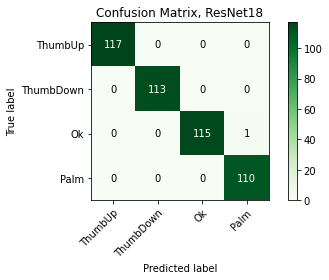

In [ ]:
class2lbl = {c: lbl for lbl, c in labels.items()}
y_true_lbls = [class2lbl[c.item()] for c in y_true]
y_pred_lbls = [class2lbl[c.item()] for c in y_pred]

plot_confusion_matrix(y_true_lbls, y_pred_lbls, classes=list(labels.keys()), title="Confusion Matrix, ResNet18")